In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate
from tensorflow.keras.models import Model

In [3]:
#read CSV file
production_df=pd.read_csv("C:\\Users\\alaaa\\jupyter lab\\veg new\\New data set\\New\\combined_output.csv")
process_df=pd.read_csv("C:\\Users\\alaaa\\jupyter lab\\veg new\\New data set\\New\\combined_output_proc.csv")

In [4]:
# Convert the 'Date' column to datetime format
#production_df['Date'] = pd.to_datetime(production_df['Date'], format='%d/%m/%Y')
#process_df['Date'] = pd.to_datetime(process_df['Date'], format='%d/%m/%Y')




In [5]:
columns=process_df.columns
columns

Index(['Status', 'Part', 'Process', 'Employee', 'Date', 'Time', 'AV Wash',
       'VYA - Batch', 'VFX - Yeast Vat', 'Code', 'VFX - Feed TS',
       'VFX - Feed SS', 'VFX - Feed IS', 'VFX - Feed Setting',
       'VFX - Beer Recycle Setting', 'VFX - Water Setting', 'VFX - Cream TS',
       'VFX - Cream SS', 'VFX - Cream IS', 'VYA - Papain Batch',
       'VYA - Papain added', 'VYA - Clerol batch', 'VYA - Vaccum Salt Added',
       'VYA - Bag Salt Batch', 'VYA - Bag Salt Added', 'VYA - 1st pH',
       'VYA - Post heat duration', 'VYA - Final Volume', 'VMBX - Auto TS',
       'VMBX - Auto SS', 'VMBX - Auto IS', 'VMBX - Auto Yield',
       'VMBX - Auto Feed', 'VMBX - Water Rate', 'VMBX - Res Recycle',
       'VMBX - Ext Flowrate', 'VMBX - Ext TS', 'VMBX - Ext SS',
       'VMBX - Ext IS', 'VMBX - Res TS', 'VMBX - Res SS', 'VMBX - Res IS',
       'VMBX - H.Residue TS', 'VMBX - H.Residue SS', 'VMBX - H.Residue IS',
       'VMBX - RISC%', 'VMBX - Res Vat', 'Code.1', 'VMBX - Res Batch',
       'V

In [6]:
# Combine "Date" and "Time" into a single datetime column
production_df['Datetime'] = pd.to_datetime(production_df['Date'] + ' ' + production_df['Time'], format='%d/%m/%Y %H:%M:%S')

# Round the time to the nearest hour to group by hour
production_df['Datetime'] = production_df['Datetime'].dt.floor('h')

# Pivot the table so that each product type appears as a column, with the corresponding yeast weight
production_pivot_df = production_df.pivot_table(index='Datetime', columns='Part', values='VYP - Yeast Weight', aggfunc='sum').reset_index()

# Display the result to the user
production_pivot_df.head(10)

Part,Datetime,Yeast - BRD,Yeast - BRN,Yeast - FMX
0,2019-10-29 02:00:00,1257.50,NaN,NaN
1,2019-10-29 03:00:00,789.00,NaN,NaN
2,2019-10-29 04:00:00,1103.50,NaN,NaN
3,2019-10-29 05:00:00,638.75,NaN,NaN
4,2019-10-29 07:00:00,618.50,NaN,NaN
5,2019-10-29 08:00:00,1248.75,NaN,NaN
6,2019-10-29 09:00:00,611.50,NaN,NaN
7,2019-10-29 10:00:00,1242.00,NaN,NaN
8,2019-10-29 11:00:00,623.75,NaN,NaN
9,2019-10-29 12:00:00,627.75,NaN,152.5


In [7]:

# Combine "Date" and "Time" into a single datetime column
process_df['Datetime'] = pd.to_datetime(process_df['Date'] + ' ' + process_df['Time'], format='%d/%m/%Y %H:%M:%S')

# Round the time to the nearest hour
process_df['Datetime'] = process_df['Datetime'].dt.floor('h')

# Select the relevant columns: Part, Datetime, and the production metrics
relevant_columns = ['Datetime', 'Part', 'VYA - Batch', 'RawYeast Volume', 'VMBX - Res IS/TS (%)']

# Filter the dataframe for these columns
process_df_filtered = process_df[relevant_columns]

# Pivot the table to have one column per product for each metric
pivot_vya = process_df_filtered.pivot_table(index='Datetime', columns='Part', values='VYA - Batch', aggfunc='sum').reset_index()
pivot_rawyeast = process_df_filtered.pivot_table(index='Datetime', columns='Part', values='RawYeast Volume', aggfunc='sum').reset_index()
pivot_vmbx = process_df_filtered.pivot_table(index='Datetime', columns='Part', values='VMBX - Res IS/TS (%)', aggfunc='mean').reset_index()

# Merge the three pivoted dataframes on the Datetime
process_merged_df = pd.merge(pivot_vya, pivot_rawyeast, on='Datetime', suffixes=('_VYA', '_RawYeast'))
process_merged_df = pd.merge(process_merged_df, pivot_vmbx, on='Datetime', suffixes=('', '_VMBX'))

# Keep only the columns of interest
columns_to_keep = ['Datetime', 
                   'Yeast - BRD_VYA', 'Yeast - BRN_VYA', 'Yeast - FMX_VYA',
                   'Yeast - BRD_RawYeast', 'Yeast - BRN_RawYeast', 'Yeast - FMX_RawYeast',
                   'Yeast - BRD', 'Yeast - BRN', 'Yeast - FMX']

# Filter the dataframe to keep only the necessary columns
process_filtered_df = process_merged_df[columns_to_keep]

# Rename the columns by adding '_proc' to the columns 'Yeast - BRD', 'Yeast - BRN', 'Yeast - FMX'
process_filtered_df = process_filtered_df.rename(columns={
    'Yeast - BRD': 'Yeast - BRD_IS/TS',
    'Yeast - BRN': 'Yeast - BRN_IS/TS',
    'Yeast - FMX': 'Yeast - FMX_IS/TS'
})

# Display the updated dataframe
process_filtered_df.head()


Part,Datetime,Yeast - BRD_VYA,Yeast - BRN_VYA,Yeast - FMX_VYA,Yeast - BRD_RawYeast,Yeast - BRN_RawYeast,Yeast - FMX_RawYeast,Yeast - BRD_IS/TS,Yeast - BRN_IS/TS,Yeast - FMX_IS/TS
0,2019-09-30 11:00:00,NaN,66.0,NaN,NaN,23113.0,NaN,NaN,80.17,NaN
1,2019-09-30 13:00:00,NaN,67.0,NaN,NaN,22087.0,NaN,NaN,80.98,NaN
2,2019-09-30 15:00:00,NaN,68.0,NaN,NaN,16776.0,NaN,NaN,80.79,NaN
3,2019-10-01 01:00:00,NaN,NaN,73.0,NaN,NaN,20000.0,NaN,NaN,80.940
4,2019-10-01 02:00:00,NaN,NaN,149.0,NaN,NaN,32145.0,NaN,NaN,80.215


In [8]:


# Merge the production and the process files
merged_df = pd.merge(process_filtered_df,production_pivot_df,  left_on='Datetime', right_on='Datetime')




In [9]:
# Set the 'Datetime' column as the index (if not already set)
merged_df['Datetime'] = pd.to_datetime(merged_df['Datetime'])  # Ensure the Datetime column is in datetime format
merged_df.set_index('Datetime', inplace=True)

#Save the result to a new CSV file
output_file = "daily_sum_weight_merg_2.csv"
merged_df.to_csv(output_file, index=True)


<Figure size 1000x600 with 0 Axes>

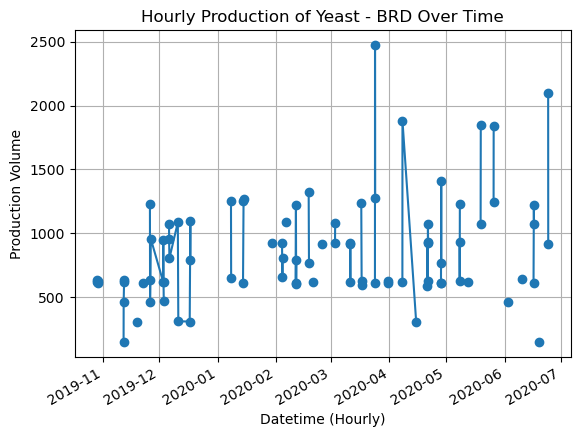

<Figure size 1000x600 with 0 Axes>

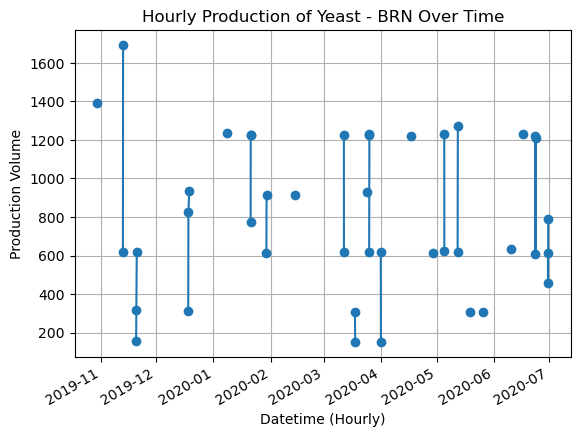

<Figure size 1000x600 with 0 Axes>

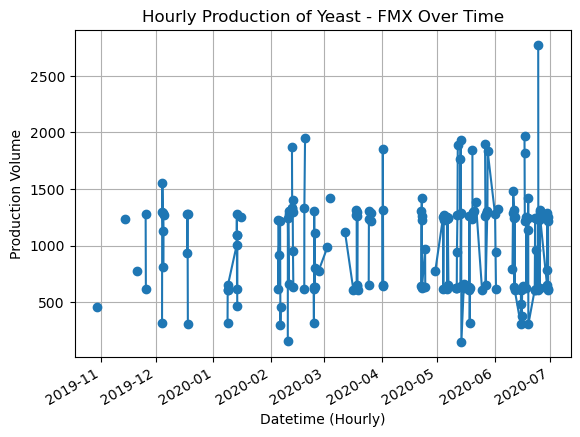

In [10]:
# Create individual plots for each product
products = ['Yeast - BRD', 'Yeast - BRN', 'Yeast - FMX']

for product in products:
    plt.figure(figsize=(10, 6))
    merged_df[[product]].plot(kind='line', marker='o', legend=False)
    plt.title(f'Hourly Production of {product} Over Time')
    plt.xlabel('Datetime (Hourly)')
    plt.ylabel('Production Volume')
    plt.grid(True)
    plt.show()

In [11]:
file_path = "C:\\Users\\alaaa\\jupyter lab\\veg new\\New data set\\New\\daily_sum_weight_merg_2.csv"



Epoch 1/100
220/220 - 4s - 17ms/step - loss: 0.0445 - val_loss: 0.0410
Epoch 2/100
220/220 - 1s - 6ms/step - loss: 0.0374 - val_loss: 0.0441
Epoch 3/100
220/220 - 1s - 6ms/step - loss: 0.0362 - val_loss: 0.0338
Epoch 4/100
220/220 - 1s - 6ms/step - loss: 0.0350 - val_loss: 0.0413
Epoch 5/100
220/220 - 1s - 6ms/step - loss: 0.0331 - val_loss: 0.0334
Epoch 6/100
220/220 - 1s - 6ms/step - loss: 0.0329 - val_loss: 0.0308
Epoch 7/100
220/220 - 1s - 6ms/step - loss: 0.0325 - val_loss: 0.0402
Epoch 8/100
220/220 - 1s - 5ms/step - loss: 0.0316 - val_loss: 0.0372
Epoch 9/100
220/220 - 1s - 6ms/step - loss: 0.0311 - val_loss: 0.0302
Epoch 10/100
220/220 - 1s - 6ms/step - loss: 0.0322 - val_loss: 0.0442
Epoch 11/100
220/220 - 1s - 6ms/step - loss: 0.0300 - val_loss: 0.0392
Epoch 12/100
220/220 - 1s - 6ms/step - loss: 0.0308 - val_loss: 0.0328
Epoch 13/100
220/220 - 1s - 6ms/step - loss: 0.0304 - val_loss: 0.0332
Epoch 14/100
220/220 - 1s - 5ms/step - loss: 0.0305 - val_loss: 0.0355
Epoch 15/100
2

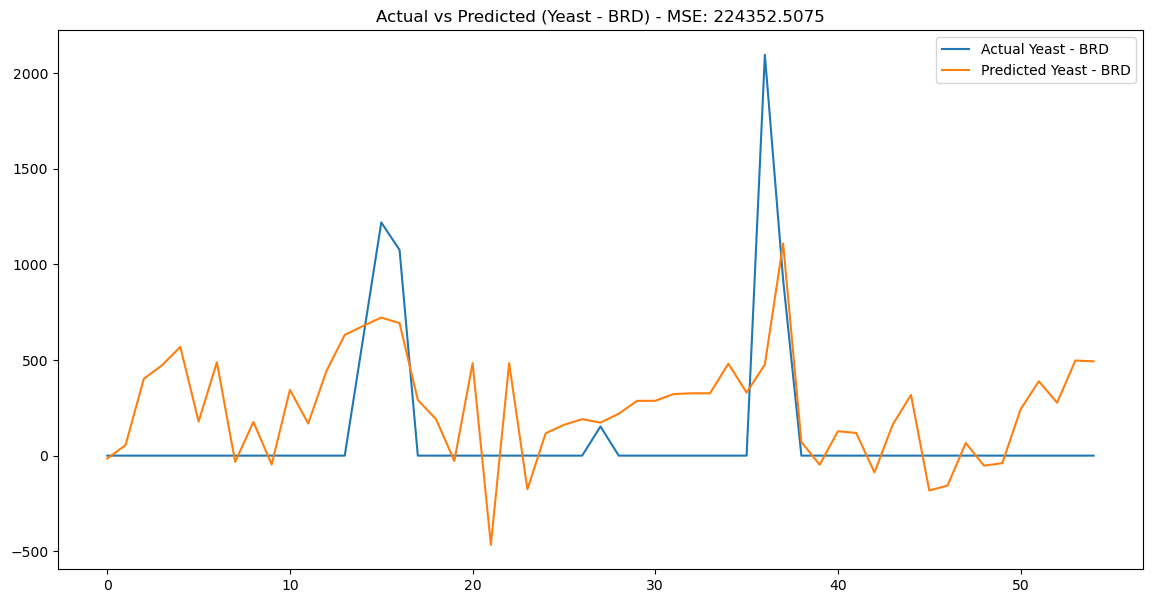

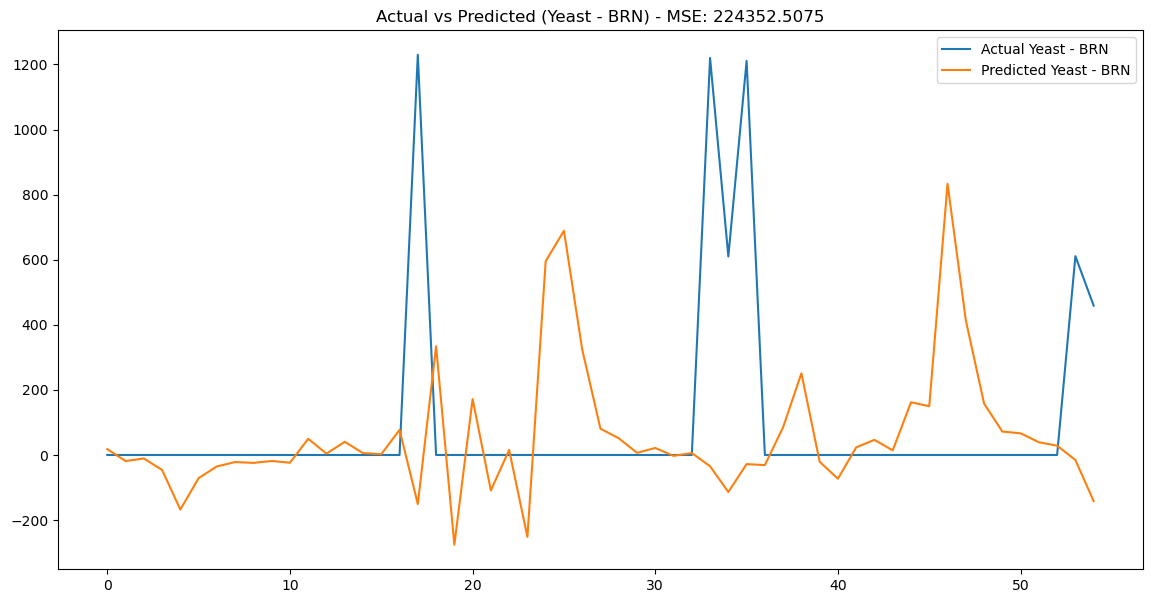

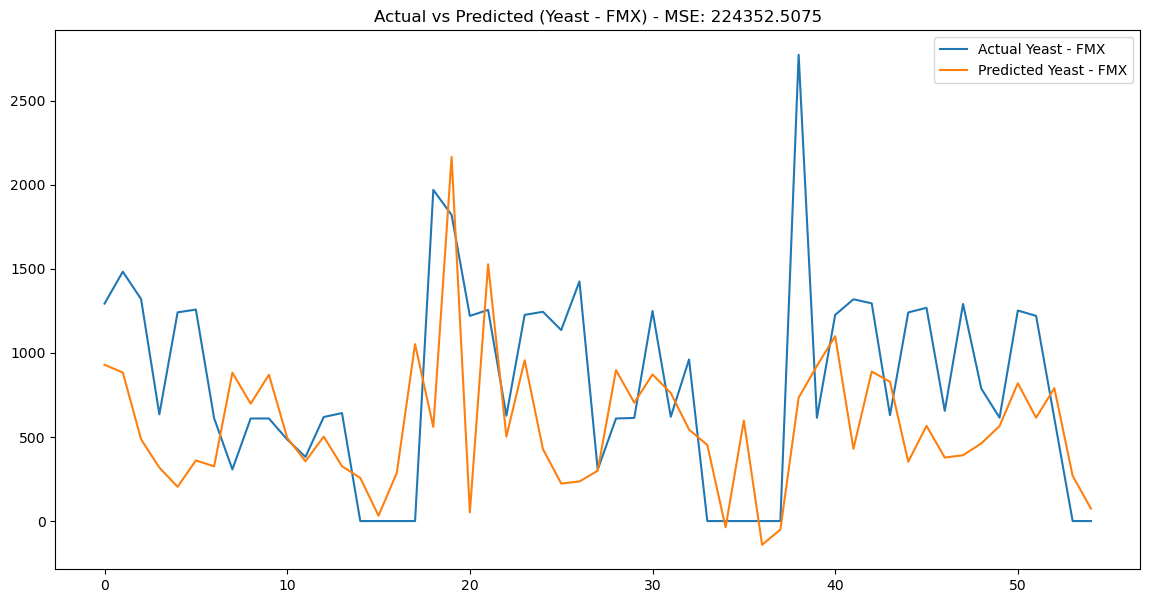

In [12]:

# Load and preprocess the data
df = pd.read_csv(file_path)
df.fillna(0, inplace=True)
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)

# Select target columns and additional input features
target_columns = ['Yeast - BRD', 'Yeast - BRN', 'Yeast - FMX']
additional_features = ['Yeast - BRD_VYA', 'Yeast - BRN_VYA', 'Yeast - FMX_VYA',
                       'Yeast - BRD_RawYeast', 'Yeast - BRN_RawYeast', 'Yeast - FMX_RawYeast',
                       'Yeast - BRD_IS/TS', 'Yeast - BRN_IS/TS', 'Yeast - FMX_IS/TS']

# Separate the target data and additional input data
target_data = df[target_columns].values
additional_input_data = df[additional_features].values

# Scaling the target columns and additional features separately
target_scaler = MinMaxScaler(feature_range=(0, 1))
additional_scaler = MinMaxScaler(feature_range=(0, 1))

scaled_target_data = target_scaler.fit_transform(target_data)
scaled_additional_data = additional_scaler.fit_transform(additional_input_data)

# Create a dataset with look-back
def create_dataset(dataset, additional_data, look_back):
    X, Y, additional = [], [], []
    for i in range(len(dataset) - look_back - 1):
        X.append(dataset[i:(i + look_back)])  # Target columns as LSTM input
        Y.append(dataset[i + look_back])      # Predict the next timestep of the target
        additional.append(additional_data[i + look_back])  # Additional features for the last timestep
    return np.array(X), np.array(Y), np.array(additional)

look_back = 30
X, Y, additional = create_dataset(scaled_target_data, scaled_additional_data, look_back)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], look_back, X.shape[2]))

# Split into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]
additional_train, additional_test = additional[:train_size], additional[train_size:]

# Define the LSTM model
input_seq = Input(shape=(look_back, 3))  # 3 target columns
x = LSTM(100, return_sequences=True)(input_seq)
x = LSTM(100, return_sequences=False)(x)

# Additional input for features at the last timestep
additional_input = Input(shape=(9,))  # 9 additional features
concatenated = Concatenate()([x, additional_input])

# Fully connected layers after concatenation
dense_1 = Dense(100)(concatenated)
output = Dense(3)(dense_1)  # Predict 3 target values (Yeast - BRD, Yeast - BRN, Yeast - FMX)

# Build and compile the model
model = Model([input_seq, additional_input], output)
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit([X_train, additional_train], Y_train, epochs=100, batch_size=1, verbose=2, validation_data=([X_test, additional_test], Y_test))

# Make predictions
test_predictions = model.predict([X_test, additional_test])

# Inverse scale only the target columns (predictions and actual values)
scaled_test_predictions = target_scaler.inverse_transform(test_predictions)
scaled_Y_test = target_scaler.inverse_transform(Y_test)

# Calculate MSE
mse = mean_squared_error(scaled_Y_test, scaled_test_predictions)

# Plot actual vs predicted for each target column
plt.figure(figsize=(14, 7))
plt.plot(scaled_Y_test[:, 0], label='Actual Yeast - BRD')
plt.plot(scaled_test_predictions[:, 0], label='Predicted Yeast - BRD')
plt.title(f'Actual vs Predicted (Yeast - BRD) - MSE: {mse:.4f}')
plt.legend()
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(scaled_Y_test[:, 1], label='Actual Yeast - BRN')
plt.plot(scaled_test_predictions[:, 1], label='Predicted Yeast - BRN')
plt.title(f'Actual vs Predicted (Yeast - BRN) - MSE: {mse:.4f}')
plt.legend()
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(scaled_Y_test[:, 2], label='Actual Yeast - FMX')
plt.plot(scaled_test_predictions[:, 2], label='Predicted Yeast - FMX')
plt.title(f'Actual vs Predicted (Yeast - FMX) - MSE: {mse:.4f}')
plt.legend()
plt.show()


In [13]:

# Extract the dates for the test data (this assumes your DataFrame has 'Datetime' as the index)
dates = df.index[-len(scaled_Y_test):]  # Adjust the range based on your test set size

# Create the DataFrame with Date & Hour, Current (Actual), and Predicted values
output_df = pd.DataFrame({
    'Date & hour': dates,
    'Current Yeast - BRD': scaled_Y_test[:, 0],
    'Predicted Yeast - BRD': scaled_test_predictions[:, 0],
    'Current Yeast - BRN': scaled_Y_test[:, 1],
    'Predicted Yeast - BRN': scaled_test_predictions[:, 1],
    'Current Yeast - FMX': scaled_Y_test[:, 2],
    'Predicted Yeast - FMX': scaled_test_predictions[:, 2],
})

# Save the DataFrame to a CSV file
output_file_path = 'lstm_predictions_output-hours.csv'  # Change this path if needed
output_df.to_csv(output_file_path, index=False)
